# CD7: semi-supervised clustering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from aicsimageio import AICSImage

# Data

In [35]:
data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203221745/")

In [36]:
ann_df = pandas.read_csv(data_dir / "annotations_dataset1_050620221854.csv").set_index("annotation__seg_id")
ann_df.columns = [f"meta_{col}" for col in ann_df.columns]

In [37]:
cat_label = CategoricalDtype(["BAD_SEGMENT", "ONELOBE", "TWOLOBES", "THREELOBES",  "FOURLOBES", "FIVELOBES", "UNCLEAR"], ordered=True)
ann_df["meta_label_name"] = ann_df["meta_label_name"].astype(cat_label)

In [38]:
df = pq.read_table(data_dir / "neutrophils.parquet").to_pandas()

In [39]:
df = ann_df.merge(df, left_index=True, right_index=True)

In [40]:
df = df.set_index(["meta_scene"]).sort_index()

In [41]:
ann_df.index.value_counts().value_counts()

1    2811
2      50
Name: annotation__seg_id, dtype: int64

# Annotation stats

<AxesSubplot:xlabel='count', ylabel='meta_label_name'>

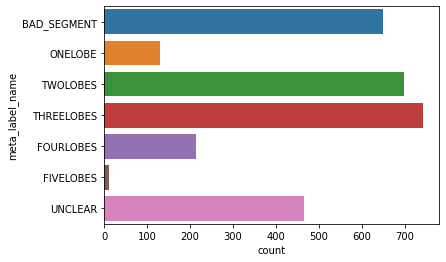

In [42]:
seaborn.countplot(data=df, y="meta_label_name")

# Plot unclear

In [13]:
scene = df[df.meta_label_name == "UNCLEAR"].groupby("meta_scene").size().idxmax()

In [15]:
im = AICSImage(df["meta_path"].iloc[0], reconstruct_mosaic=False)
im.set_scene(scene)

In [21]:
tmp_df = df.loc[scene][df.loc[scene].meta_label_name == "UNCLEAR"]

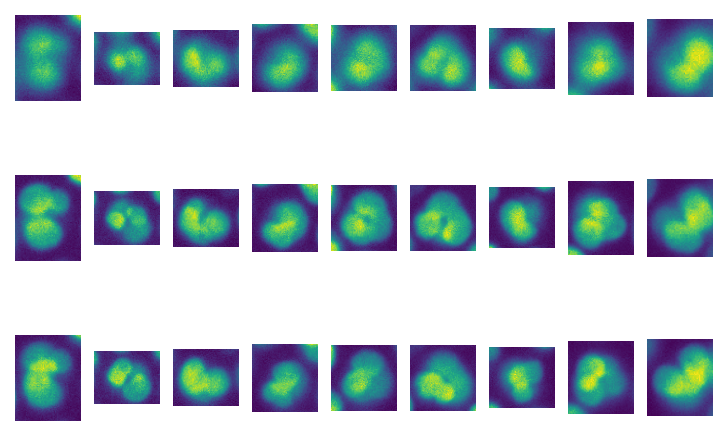

In [30]:
fig, axes = plt.subplots(3, len(tmp_df), dpi=150)
pixels = im.get_image_data("ZXY", C=0)

for axes_row, (idx, r) in zip(axes.T, tmp_df.iterrows()):
    minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])
    for i, ax in enumerate(axes_row):
        ax.imshow(pixels[i, minr:maxr, minc:maxc])
        ax.set_axis_off()
        
plt.savefig("unclear.png")

# Plot bad

In [42]:
scene = df[df.meta_label_name == "BAD_SEGMENT"].groupby("meta_scene").size().idxmax()

In [43]:
im = AICSImage(df["meta_path"].iloc[0], reconstruct_mosaic=False)
im.set_scene(scene)

In [47]:
tmp_df = df.loc[scene][df.loc[scene].meta_label_name == "BAD_SEGMENT"].drop_duplicates(subset="meta_id", keep="last")

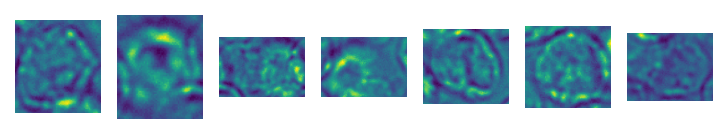

In [48]:
fig, axes = plt.subplots(1, len(tmp_df), dpi=150)
pixels = im.get_image_data("ZXY", C=4)[0]

for ax, (idx, r) in zip(axes, tmp_df.iterrows()):
    minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])
    ax.imshow(pixels[minr:maxr, minc:maxc])
    ax.set_axis_off()
        
plt.savefig("unclear.png", dpi=300, bbox_inches="tight")

# Plot annotations

In [11]:
im = AICSImage(df["meta_path"].iloc[0], reconstruct_mosaic=False)

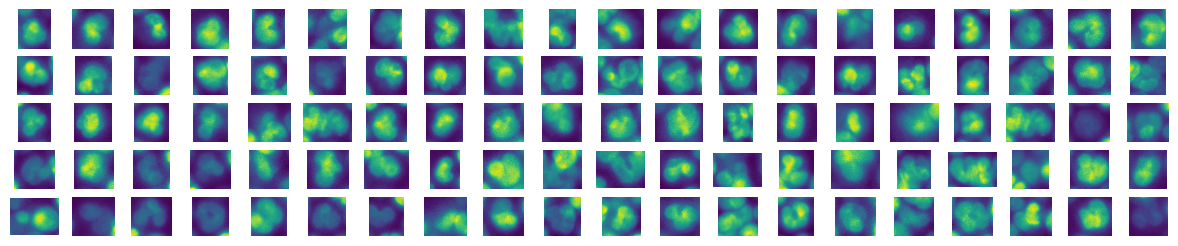

In [30]:
c = "BAD_SEGMENT"
fig, axes = plt.subplots(5, 20, figsize=(15, 3), dpi=100)
axes = axes.ravel()

for ax, (_, r) in zip(axes, df[df["meta_label_name"] == c].reset_index().sample(n=100).iterrows()):
    im.set_scene(r.meta_scene)
    pixels = numpy.max(im.get_image_data("ZXY", C=0), axis=0)
    minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])
    ax.imshow(pixels[minr:maxr, minc:maxc])
    ax.set_axis_off()

BAD_SEGMENT
ONELOBE
TWOLOBES
THREELOBES
FOURLOBES
FIVELOBES
UNCLEAR


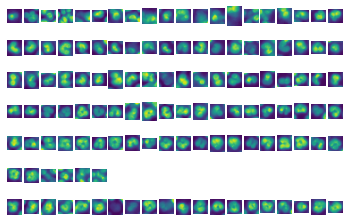

In [97]:
n = 20
fig, axes = plt.subplots(len(df["meta_label"].unique()), n)

for axes_row, (c, gdf) in zip(axes, df.groupby("meta_label_name")):
    print(c)
    n_ = min(n, len(gdf))
    
    i = 0
    for scene, sdf in gdf.iloc[:n_].groupby("meta_scene"):
        im.set_scene(scene)
        pixels = numpy.max(im.get_image_data("ZXY", C=0), axis=0)
        
        for idx, r in sdf.iterrows():
            minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])
            axes_row[i].imshow(pixels[minr:maxr, minc:maxc])
            i+=1
        
for ax in axes.ravel():
    ax.set_axis_off()

# Classification

In [96]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

from sklearn.preprocessing import scale, StandardScaler

In [44]:
sel = ~df.meta_label_name.isin(["UNCLEAR", "BAD_SEGMENT"])

In [98]:
pipeline = make_pipeline(
    StandardScaler(),
    RandomOverSampler(random_state=0),
    LogisticRegression(random_state=0, max_iter=10000)
)

In [109]:
pipeline = make_pipeline(
    StandardScaler(),
    RandomOverSampler(random_state=0),
    DecisionTreeClassifier(random_state=0)
)

In [103]:
train_idx, test_idx = train_test_split(numpy.arange(len(df))[sel], test_size=0.1, random_state=0)

In [110]:
pipeline.fit(df.iloc[train_idx].filter(regex="(Oblique|PGC|Bright)"), df.iloc[train_idx].meta_label)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomoversampler', RandomOverSampler(random_state=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=0))])

In [111]:
y_pred = pipeline.predict(df.iloc[test_idx].filter(regex="(Oblique|PGC|Bright)"))
balanced_accuracy_score(df.iloc[test_idx].meta_label, y_pred)

0.25294920206168514

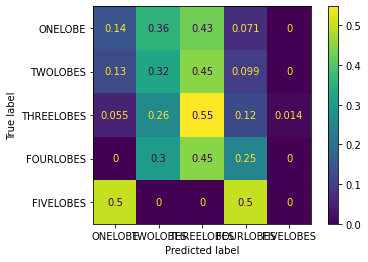

In [112]:
ConfusionMatrixDisplay.from_predictions(df.iloc[test_idx].meta_label, y_pred, display_labels=df.iloc[test_idx].meta_label_name.unique().sort_values(), normalize='true')